In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
import seaborn as sns

In [2]:
train_df = pd.read_csv('UNSW_NB15_train-set.csv').drop("id", axis=1)
test_df = pd.read_csv('UNSW_NB15_test-set.csv').drop("id", axis=1)

In [3]:
# combining the data into one frame
train_df['source'] = 'train'
test_df['source'] = 'test'

all_df = pd.concat([train_df, test_df])

# encoding categorical values
_numerical = all_df.dtypes[all_df.dtypes!=object].index.tolist()[:-1]
_categorical = all_df.dtypes[all_df.dtypes == object].index.tolist()[:-2]
_categorical_data = pd.get_dummies(all_df[_categorical])

all_df = all_df.drop(_categorical, axis=1)
all_df = pd.concat([all_df, _categorical_data], axis=1)

# splitting it back
train_df = all_df[all_df.source=='train'].copy().drop('source', axis=1)
test_df = all_df[all_df.source=='test'].copy().drop('source', axis=1)

# separate categroicals with non categoricals 
# train set
rbs= RobustScaler()
rbs.fit(train_df[_numerical])

train_df[_numerical] = rbs.transform(train_df[_numerical])
test_df[_numerical] = rbs.transform(test_df[_numerical])

output1 = train_df[['attack_cat']].copy()  # multiclass
output2 = train_df[['label']].copy()       # binary

# test set
test_output1 = test_df[['attack_cat']].copy()  # multiclass
test_output2 = test_df[['label']].copy()       # binary

train_df = train_df.drop(['attack_cat', 'label'], axis=1)
test_df = test_df.drop(['attack_cat', 'label'], axis=1)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

train_df_c = add_constant(train_df)

vif_data = pd.DataFrame({
    'feature': _numerical,
    'VIF': [variance_inflation_factor(train_df_c[_numerical].values, i) for i in range(len(_numerical))]
})
max_vif = vif_data.sort_values('VIF', ascending=False).iloc[0, 1]
to_drop = vif_data.sort_values('VIF', ascending=False).iloc[0, 0]
_data = train_df_c.copy()

while max_vif>5:
    _data = _data.drop(to_drop, axis=1)
    
    print(f'Dropped: \t {to_drop} \t {max_vif}')
    
    vif_data = pd.DataFrame({
        'feature': _data.columns,
        'VIF': [variance_inflation_factor(_data.values, i) for i in range(len(_data.columns))]
    })
    
    max_vif = vif_data.sort_values('VIF', ascending=False).iloc[0, 1]
    to_drop = vif_data.sort_values('VIF', ascending=False).iloc[0, 0]    

In [4]:
from time import time
from sklearn.tree import DecisionTreeClassifier


#Calculate start time
start = time()

# training model
classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', splitter='best')
classifier.fit(train_df, output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df)

#Calculate Stop time
test_time= time() - start

print('Training Complete')

Training Complete


                precision    recall  f1-score   support

      Analysis       0.02      0.09      0.03       677
      Backdoor       0.02      0.09      0.03       583
           DoS       0.28      0.19      0.23      4089
      Exploits       0.61      0.67      0.64     11132
       Fuzzers       0.25      0.43      0.31      6062
       Generic       0.98      0.97      0.98     18871
        Normal       0.95      0.74      0.83     37000
Reconnaissance       0.90      0.80      0.85      3496
     Shellcode       0.31      0.69      0.43       378
         Worms       0.48      0.50      0.49        44

      accuracy                           0.73     82332
     macro avg       0.48      0.52      0.48     82332
  weighted avg       0.81      0.73      0.76     82332

Accuracy: 0.7279915464218044
Precision: 0.8081328424040876
Recall: 0.7279915464218044
F1 score: 0.7592534016417047
Train Time(s):  8.514317274093628
Test Time(s):  0.19900298118591309


<AxesSubplot: >

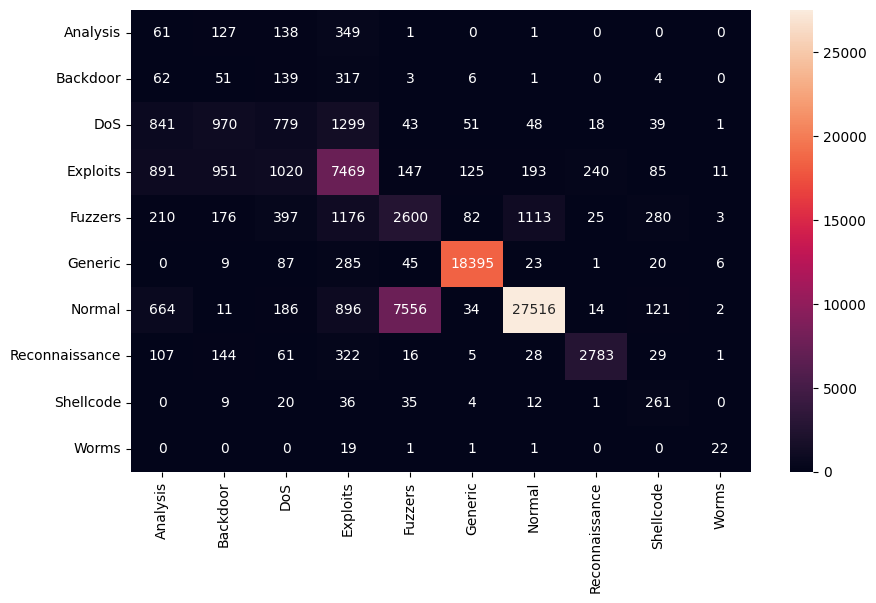

In [7]:
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

In [8]:
from time import time
from sklearn.ensemble import RandomForestClassifier

#Calculate start time
start = time()

# training model
classifier = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=1)
classifier.fit(train_df, output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df)

#Calculate Stop time
test_time= time() - start

print('Training Complete')

C:\Users\Devayani\AppData\Local\Temp\ipykernel_1896\3130109159.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(train_df, output1)


Training Complete


                precision    recall  f1-score   support

      Analysis       0.01      0.03      0.02       677
      Backdoor       0.02      0.07      0.03       583
           DoS       0.24      0.16      0.19      4089
      Exploits       0.61      0.65      0.63     11132
       Fuzzers       0.26      0.46      0.33      6062
       Generic       0.98      0.96      0.97     18871
        Normal       0.92      0.75      0.83     37000
Reconnaissance       0.84      0.77      0.80      3496
     Shellcode       0.22      0.48      0.30       378
         Worms       0.11      0.11      0.11        44

      accuracy                           0.72     82332
     macro avg       0.42      0.44      0.42     82332
  weighted avg       0.79      0.72      0.75     82332

Accuracy: 0.7237890492153719
Precision: 0.7869285863641122
Recall: 0.7237890492153719
F1 score: 0.7489151297873567
Train Time(s):  1.2108793258666992
Test Time(s):  0.18003225326538086


<AxesSubplot: >

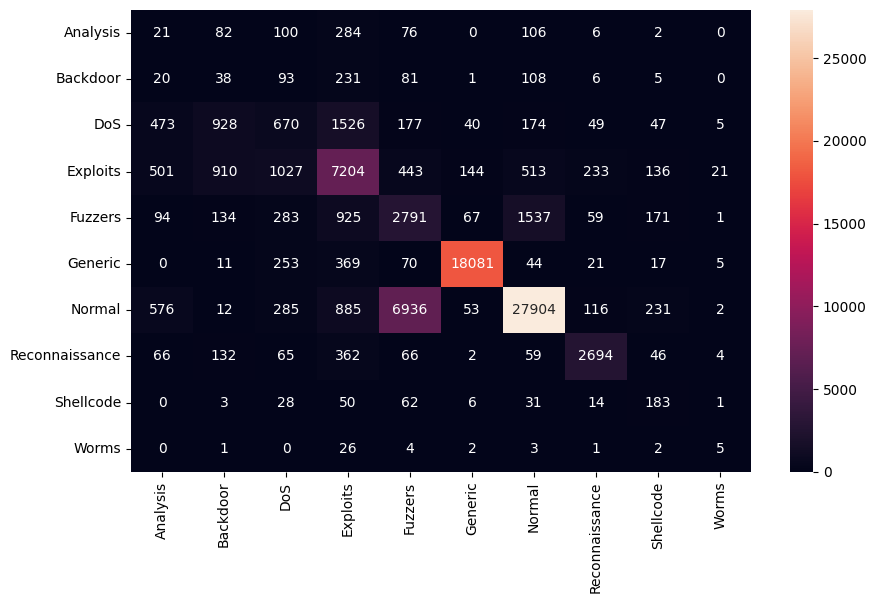

In [9]:
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

In [10]:
from time import time
from sklearn.linear_model import LogisticRegression

#Calculate start time
start = time()

# training model
classifier = LogisticRegression(solver= 'lbfgs')
classifier.fit(train_df, output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df)

#Calculate Stop time
test_time= time() - start

print('Training Complete')

c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Complete


c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.00      0.00      0.00       583
           DoS       0.14      0.00      0.00      4089
      Exploits       0.41      0.33      0.37     11132
       Fuzzers       0.27      0.06      0.10      6062
       Generic       0.57      0.96      0.72     18871
        Normal       0.72      0.78      0.75     37000
Reconnaissance       0.00      0.00      0.00      3496
     Shellcode       0.00      0.00      0.00       378
         Worms       0.00      0.00      0.00        44

      accuracy                           0.62     82332
     macro avg       0.21      0.21      0.19     82332
  weighted avg       0.54      0.62      0.56     82332

Accuracy: 0.6214473108876257


c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5384160786044689
Recall: 0.6214473108876257
F1 score: 0.559004255071753
Train Time(s):  56.50682997703552
Test Time(s):  0.16018223762512207


<AxesSubplot: >

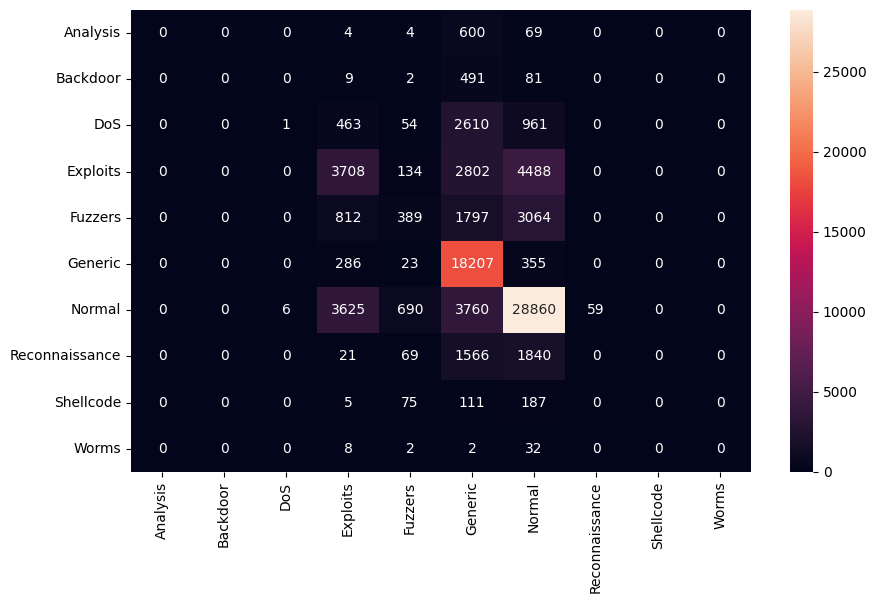

In [11]:
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

In [12]:
from time import time
from sklearn.neighbors import KNeighborsClassifier

#Calculate start time
start = time()

# training model
classifier = KNeighborsClassifier(n_neighbors=5,metric='euclidean',p=2)
classifier.fit(train_df, output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df)

#Calculate Stop time
test_time= time() - start

print('Training Complete')

c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training Complete


                precision    recall  f1-score   support

      Analysis       0.02      0.05      0.03       677
      Backdoor       0.03      0.09      0.04       583
           DoS       0.30      0.27      0.28      4089
      Exploits       0.63      0.68      0.66     11132
       Fuzzers       0.28      0.51      0.36      6062
       Generic       0.99      0.97      0.98     18871
        Normal       0.94      0.74      0.83     37000
Reconnaissance       0.67      0.76      0.71      3496
     Shellcode       0.37      0.36      0.36       378
         Worms       0.56      0.11      0.19        44

      accuracy                           0.73     82332
     macro avg       0.48      0.45      0.44     82332
  weighted avg       0.80      0.73      0.76     82332

Accuracy: 0.7321940436282369
Precision: 0.7994548211378922
Recall: 0.7321940436282369
F1 score: 0.7575570924942244
Train Time(s):  0.631169319152832
Test Time(s):  166.06850218772888


<AxesSubplot: >

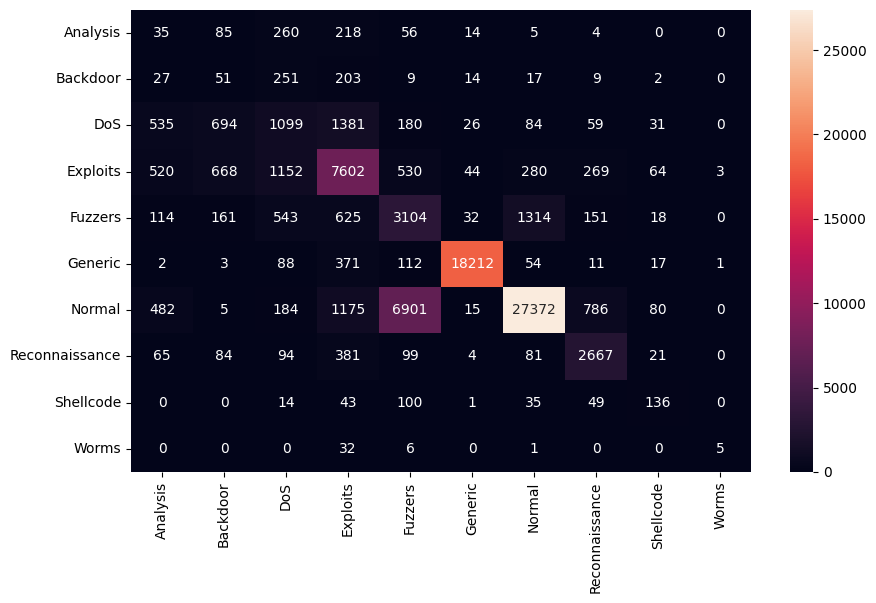

In [13]:
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

In [16]:
from time import time
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
output1_lencoded = le.fit_transform(output1)

#Calculate start time
start = time()

# training model
classifier = XGBClassifier(random_state=42)
classifier.fit(train_df, output1_lencoded)

#Calculate Stop time
train_time = time() - start

#Calculate start time
start = time()
pred_y = classifier.predict(test_df)

#Calculate Stop time
test_time= time() - start

print('Training Complete')

c:\users\devayani\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Complete


                precision    recall  f1-score   support

      Analysis       0.05      0.09      0.06       677
      Backdoor       0.03      0.09      0.05       583
           DoS       0.45      0.11      0.18      4089
      Exploits       0.61      0.85      0.71     11132
       Fuzzers       0.31      0.57      0.40      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.96      0.76      0.85     37000
Reconnaissance       0.93      0.81      0.86      3496
     Shellcode       0.37      0.82      0.51       378
         Worms       0.71      0.57      0.63        44

      accuracy                           0.77     82332
     macro avg       0.54      0.56      0.52     82332
  weighted avg       0.83      0.77      0.78     82332

Accuracy: 0.7683039401447797
Precision: 0.8289075396911612
Recall: 0.7683039401447797
F1 score: 0.7824581459672407
Train Time(s):  752.5074167251587
Test Time(s):  1.749053716659546


<AxesSubplot: >

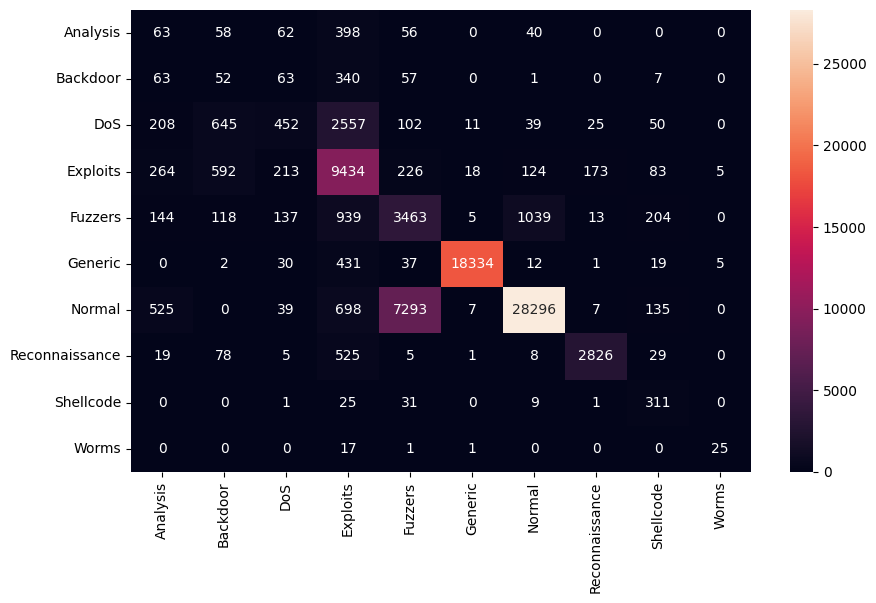

In [21]:
print(classification_report(test_output1, le.inverse_transform(pred_y)))

# performance
print('Accuracy:',  accuracy_score (test_output1, le.inverse_transform(pred_y)))
print("Precision:", precision_score(test_output1, le.inverse_transform(pred_y) ,average='weighted'))
print("Recall:",    recall_score   (test_output1, le.inverse_transform(pred_y), average='weighted'))
print("F1 score:",  f1_score       (test_output1, le.inverse_transform(pred_y), average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, le.inverse_transform(pred_y), 
        labels=le.classes_
    ), columns=le.classes_, index=le.classes_), annot=True, fmt="g")

___

In [ ]:
# training over numerical only

Training Complete
                precision    recall  f1-score   support

      Analysis       0.03      0.10      0.04       677
      Backdoor       0.04      0.10      0.05       583
           DoS       0.33      0.17      0.22      4089
      Exploits       0.60      0.71      0.65     11132
       Fuzzers       0.24      0.43      0.31      6062
       Generic       0.98      0.96      0.97     18871
        Normal       0.94      0.74      0.83     37000
Reconnaissance       0.89      0.79      0.83      3496
     Shellcode       0.22      0.61      0.32       378
         Worms       0.38      0.41      0.40        44

      accuracy                           0.73     82332
     macro avg       0.46      0.50      0.46     82332
  weighted avg       0.80      0.73      0.76     82332

Accuracy: 0.7299591896225041
Precision: 0.8031518003642011
Recall: 0.7299591896225041
F1 score: 0.7567611396742726
Train Time(s):  7.311348915100098
Test Time(s):  0.0662682056427002


<AxesSubplot: >

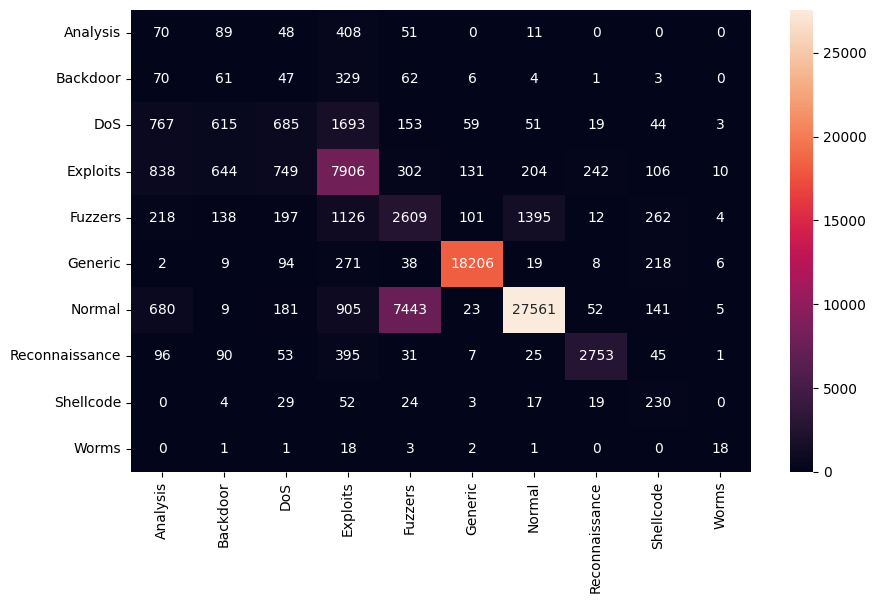

In [22]:
#Calculate start time
start = time()

# training model
classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', splitter='best')
classifier.fit(train_df[_numerical], output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df[_numerical])

#Calculate Stop time
test_time= time() - start

print('Training Complete')
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

C:\Users\Devayani\AppData\Local\Temp\ipykernel_1896\4007455637.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(train_df[_numerical], output1)


Training Complete
                precision    recall  f1-score   support

      Analysis       0.05      0.18      0.08       677
      Backdoor       0.02      0.04      0.02       583
           DoS       0.29      0.16      0.21      4089
      Exploits       0.62      0.66      0.64     11132
       Fuzzers       0.26      0.49      0.34      6062
       Generic       0.96      0.93      0.94     18871
        Normal       0.92      0.75      0.83     37000
Reconnaissance       0.77      0.74      0.76      3496
     Shellcode       0.16      0.45      0.23       378
         Worms       0.23      0.23      0.23        44

      accuracy                           0.72     82332
     macro avg       0.43      0.46      0.43     82332
  weighted avg       0.79      0.72      0.74     82332

Accuracy: 0.7197687411941894
Precision: 0.786235423212214
Recall: 0.7197687411941894
F1 score: 0.7449321103727077
Train Time(s):  1.0487191677093506
Test Time(s):  0.047232866287231445


<AxesSubplot: >

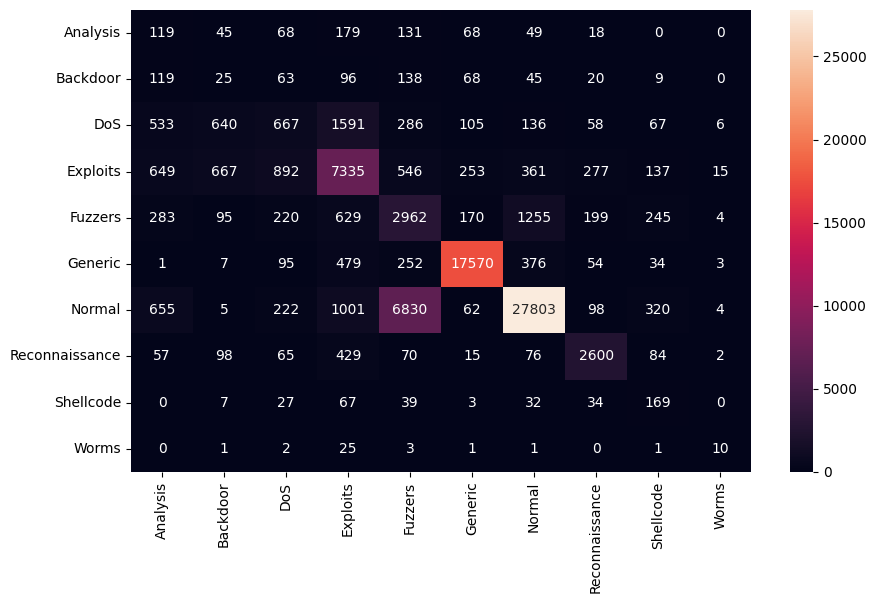

In [24]:
#Calculate start time
start = time()

# training model
classifier = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=1)
classifier.fit(train_df[_numerical], output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df[_numerical])

#Calculate Stop time
test_time= time() - start

print('Training Complete')
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

Training Complete
                precision    recall  f1-score   support

      Analysis       0.03      0.10      0.04       677
      Backdoor       0.04      0.10      0.05       583
           DoS       0.33      0.17      0.22      4089
      Exploits       0.60      0.71      0.65     11132
       Fuzzers       0.24      0.43      0.31      6062
       Generic       0.98      0.96      0.97     18871
        Normal       0.94      0.74      0.83     37000
Reconnaissance       0.89      0.79      0.83      3496
     Shellcode       0.22      0.61      0.32       378
         Worms       0.38      0.41      0.40        44

      accuracy                           0.73     82332
     macro avg       0.46      0.50      0.46     82332
  weighted avg       0.80      0.73      0.76     82332

Accuracy: 0.7299591896225041
Precision: 0.8031518003642011
Recall: 0.7299591896225041
F1 score: 0.7567611396742726
Train Time(s):  7.248823404312134
Test Time(s):  0.03988957405090332


<AxesSubplot: >

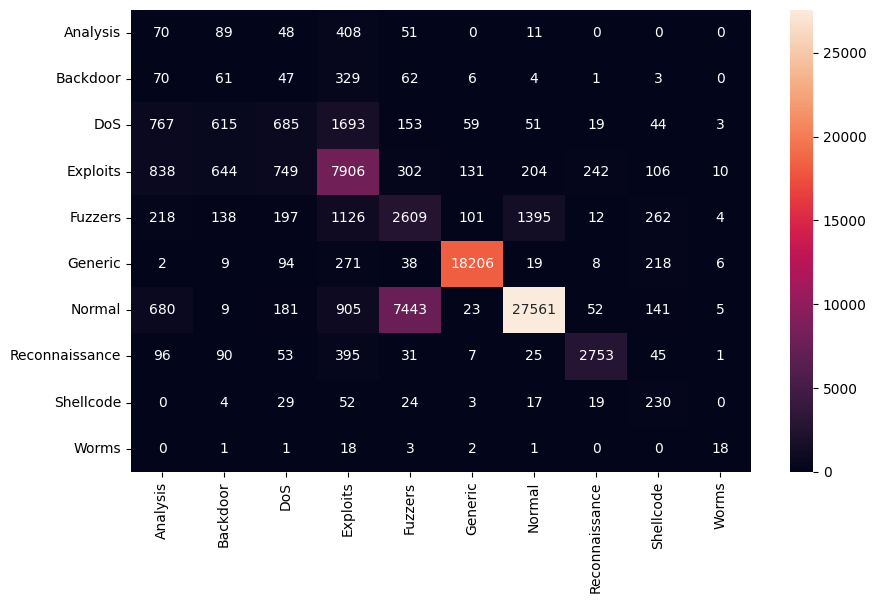

In [25]:
#Calculate start time
start = time()

# training model
classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', splitter='best')
classifier.fit(train_df[_numerical], output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df[_numerical])

#Calculate Stop time
test_time= time() - start

print('Training Complete')
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

In [ ]:
#Calculate start time
start = time()

# training model
classifier = (random_state=42, criterion='entropy', splitter='best')
classifier.fit(train_df[_numerical], output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df[_numerical])

#Calculate Stop time
test_time= time() - start

print('Training Complete')
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")

___

In [ ]:
# switch RF with any other classifier in the sections below

In [ ]:
from time import time
from sklearn.ensemble import RandomForestClassifier

#Calculate start time
start = time()

# training model
classifier = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=1)
classifier.fit(train_df, output1)

#Calculate Stop time
train_time= time() - start


#Calculate start time
start = time()
pred_y = classifier.predict(test_df)

#Calculate Stop time
test_time= time() - start

print('Training Complete')

In [ ]:
print(classification_report(test_output1, pred_y))

# performance
print('Accuracy:',  accuracy_score (test_output1, pred_y))
print("Precision:", precision_score(test_output1, pred_y ,average='weighted'))
print("Recall:",    recall_score   (test_output1, pred_y, average='weighted'))
print("F1 score:",  f1_score       (test_output1, pred_y, average='weighted'))

# time taken
print('Train Time(s): ',train_time) 
print('Test Time(s): ',test_time)

# confusion matrix code goes here
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=6)
_col_ord = test_output1.attack_cat.unique().tolist()

sns.heatmap(
    pd.DataFrame(confusion_matrix(
        test_output1, pred_y, 
        labels=classifier.classes_
    ), columns=classifier.classes_, index=classifier.classes_), annot=True, fmt="g")